In [1]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from src.utils.data_loader import LoadDataSet, CustomDataSet
from src.positioning.toa import toa_positioning
from src.utils.models import DenseNet
from sklearn.decomposition import PCA
from torchsummary import summary
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import tikzplotlib
import torch
import os
%matplotlib inline
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### PCA Analysis

#### PCA with All Features Data
In this case we consider the data associated with each path, BS, and charcteristic (the 6 features for each path) as a unique set of features of dimension 600.

In [2]:
# Load the dataset with all the paths
dir_name = "Omni Spatial and Temporal Data/"
all_paths_dataset = LoadDataSet(dir_name, path_mode="all_paths")
print(f"Random shuffling state: {all_paths_dataset.rnd_state}")
scaler = StandardScaler()
train_set, test_set = all_paths_dataset.get_datasets(scale=True, scaler=scaler, add_noise=True)
train_dl = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_set, batch_size=1024, shuffle=False)

54582
The shape of the feature data is (150000, 4, 25, 6)
The shape of the target data is: (150000, 3)
Random shuffling state: 3
The shape of the training data is: (75000, 4, 25, 6)
The shape of the testing data is: (75000, 4, 25, 6)
new training shape: (75000, 600)


In [3]:
# create the sk-learn PCA object and fit the training data
pca_all = PCA()
pca_all_components = pca_all.fit(train_set.X)

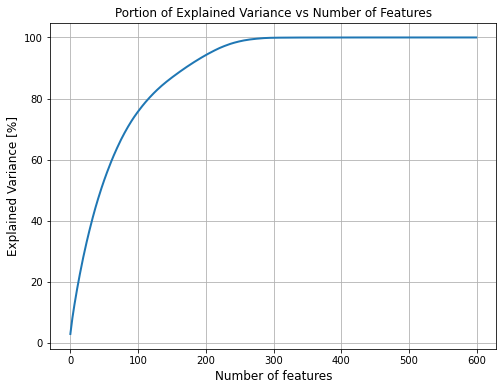

In [4]:
# let's visualize the amount of explained variance by increasing number of considered features
cum_explained_var = np.cumsum(pca_all_components.explained_variance_ratio_ * 100)
plt.figure(figsize=(8,6))
plt.plot(cum_explained_var, linewidth=2)
plt.xlabel("Number of features", fontsize=12)
plt.ylabel("Explained Variance [%]", fontsize=12)
plt.title("Portion of Explained Variance vs Number of Features")
plt.grid()

tikzplotlib.save("./figures/explained_variance_noise_newarch.tex")

In [5]:
# retain a number of features with which we can explain at least 95 % of the total variance
I = np.where(cum_explained_var >= 95)[0]
num_features_95 = I[0]
print(f"The number of features needed to explain 95 % of the variance is: {num_features_95}")

# create an sk-learn PCA object with the above number of components
pca_95 = PCA(n_components=I[0])
x_train_95 = pca_95.fit_transform(train_set.X)
x_test_95 = pca_95.transform(test_set.X)
print(f"The reduced training data has shape: {x_train_95.shape}")
print(f"The percentage of explained variance is: {np.sum(pca_95.explained_variance_ratio_)*100}")

# create data loaders with the nre reduced data
train_95_dl = torch.utils.data.DataLoader(CustomDataSet(x_train_95, train_set.y), batch_size=32, shuffle=True)
test_95_dl = torch.utils.data.DataLoader(CustomDataSet(x_test_95, test_set.y), batch_size=1024, shuffle=False)

The number of features needed to explain 95 % of the variance is: 207
The reduced training data has shape: (75000, 207)
The percentage of explained variance is: 94.86528255697881


#### PCA for each feature
In this case we consider the data associated with the 6 features (delay, rx power, and the 4 angles of arrival and departure).
Specifically, based on the PCA of the data matrix, we select the 3 features that have the highest explanation power in the dataset. Each feature has 100 singular values associated (25 paths x 4 Base Stations)

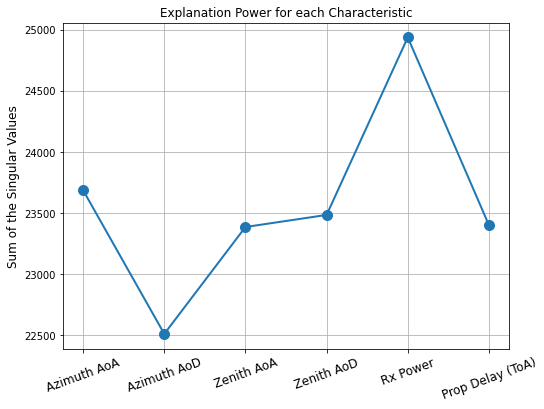

In [6]:
# we consider a PCA with 1 Principal Component to obtain the importance associated whith each characteristic
num_charac = 6
sinv_charac = np.zeros((num_charac, 1))
for i in range(num_charac):
    data = train_set.X[:, i*100:(i+1)*100]
    pca_i = PCA(100)
    pca_i_comp = pca_i.fit(data)
    sinv_charac[i] = np.sum(pca_i_comp.singular_values_)
    
plt.figure(figsize=(8,6))
plt.plot(sinv_charac, '-o', markersize=10, linewidth=2)
plt.ylabel("Sum of the Singular Values", fontsize=12)
plt.grid()
plt.title("Explanation Power for each Characteristic")
plt.xticks(np.arange(6), ["Azimuth AoA","Azimuth AoD","Zenith AoA","Zenith AoD","Rx Power","Prop Delay (ToA)"], rotation=20, fontsize=12)

tikzplotlib.save("./figures/characteristics_noise_newarch.tex")

From the plot above we can see that the 3 most important features are: Zenith AoD, Rx Power, and Propagation Delay.
Therefore, we will consider as input to our models the 100 samples (25x4) associated with these 3 characteristics, for a total of 300 features.

In [7]:
# get the full dataset
dir_name = "Omni Spatial and Temporal Data/"
full_dataset = LoadDataSet(dir_name, path_mode="all_paths")
print(f"Random shuffling state: {all_paths_dataset.rnd_state}")
scaler = StandardScaler()
(x_train, y_train), (x_test, y_test) = full_dataset.get_datasets(get_full_data=True, add_noise=True)

# selecting the feature corresponding to zenith AoD, Rx Power, and Propagation Delay (ToA) 
# [last 3 indexes in the right-most dimension]
x_train = np.reshape(x_train[:,:,:, [0,3,4]], (x_train.shape[0],x_train.shape[1]*x_train.shape[2]*3))
x_test = np.reshape(x_test[:,:,:,[0,3,4]], (x_test.shape[0],x_test.shape[1]*x_test.shape[2]*3))
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test) 
train_set = CustomDataSet(x_train, y_train)
test_set = CustomDataSet(x_test, y_test)

train_feature_based_dl = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_feature_based_dl = torch.utils.data.DataLoader(test_set, batch_size=1024, shuffle=False)

54582
The shape of the feature data is (150000, 4, 25, 6)
The shape of the target data is: (150000, 3)
Random shuffling state: 3
The shape of the training data is: (75000, 4, 25, 6)
The shape of the testing data is: (75000, 4, 25, 6)


## Train with the 95% variance explained features

In [8]:
in_dim = num_features_95
out_dim = all_paths_dataset.output_shape

# new deeper architecture for noisy data
layers_dim = [in_dim, 200, 100, 200, 100, out_dim]

dnn_model_95 = DenseNet(layers_dim)
dnn_model_95.to(device)
summary(dnn_model_95, input_data=(1,in_dim), device=device, depth=len(layers_dim))

Loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(dnn_model_95.parameters(), lr=0.001, amsgrad=False)

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Linear: 2-1                       [-1, 1, 200]              41,600
|    └─Linear: 2-2                       [-1, 1, 100]              20,100
|    └─Linear: 2-3                       [-1, 1, 200]              20,200
|    └─Linear: 2-4                       [-1, 1, 100]              20,100
|    └─Linear: 2-5                       [-1, 1, 3]                303
Total params: 102,303
Trainable params: 102,303
Non-trainable params: 0
Total mult-adds (M): 0.10
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.39
Estimated Total Size (MB): 0.40


In [9]:
# train the model
train_loss_history = []
test_loss_history = []
n_epochs = 500

for epoch in range(n_epochs):
    total_train_loss = 0
    total_test_loss = 0
    total_train = 0
    total_test = 0

    # training loop (iterate over the training set)
    for x, y in train_95_dl:
        x_train, y_train = x.float().to(device), y.float().to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        train_output = dnn_model_95(x_train) # network output
        loss = Loss(train_output, y_train) # compute loss
        loss.backward() # compute gradient with respect to trainable parameters
        optimizer.step() # weights update
        total_train_loss += loss.item()
        total_train += 1

    print(f"Training at epoch: {epoch+1} ended, Loss: {total_train_loss/total_train}")
    # append training loss for the epoch
    train_loss_history.append(total_train_loss/total_train)

    # testing every 10 training epochs
    if ((epoch+1) % 10) == 0:
        for x, y in test_95_dl:
            x_test, y_test = x.float().to(device), y.float().to(device)
            test_output = dnn_model_95(x_test)
            loss = Loss(test_output, y_test)
            total_test_loss += loss.item()
            total_test += 1
        print(f"--> Testing at epoch: {epoch+1} ended, Loss: {total_test_loss/total_test}")
        # append test loss for the epoch
        test_loss_history.append(total_test_loss/total_test)

print('Finished Training')

Training at epoch: 1 ended, Loss: 19032.05821962324
Training at epoch: 2 ended, Loss: 3697.481897894433
Training at epoch: 3 ended, Loss: 1304.4783400838285
Training at epoch: 4 ended, Loss: 939.3941741136153
Training at epoch: 5 ended, Loss: 765.5404885002371
Training at epoch: 6 ended, Loss: 616.4349940433437
Training at epoch: 7 ended, Loss: 517.2490879358285
Training at epoch: 8 ended, Loss: 452.08792330380595
Training at epoch: 9 ended, Loss: 393.1901737772971
Training at epoch: 10 ended, Loss: 349.196942534463
--> Testing at epoch: 10 ended, Loss: 1420.3213740168392
Training at epoch: 11 ended, Loss: 332.29375753305067
Training at epoch: 12 ended, Loss: 299.50587848754463
Training at epoch: 13 ended, Loss: 296.16255883877596
Training at epoch: 14 ended, Loss: 219.3848413379526
Training at epoch: 15 ended, Loss: 342.36398150082744
Training at epoch: 16 ended, Loss: 163.2756739899567
Training at epoch: 17 ended, Loss: 154.46416141392834
Training at epoch: 18 ended, Loss: 146.481072

--> Testing at epoch: 140 ended, Loss: 715.3863701691498
Training at epoch: 141 ended, Loss: 23.443730745706134
Training at epoch: 142 ended, Loss: 56.58523449556006
Training at epoch: 143 ended, Loss: 22.471307731936
Training at epoch: 144 ended, Loss: 19.31139506862432
Training at epoch: 145 ended, Loss: 20.647650583408797
Training at epoch: 146 ended, Loss: 22.8171462050477
Training at epoch: 147 ended, Loss: 18.661658954091447
Training at epoch: 148 ended, Loss: 25.28741368397104
Training at epoch: 149 ended, Loss: 17.53234753470372
Training at epoch: 150 ended, Loss: 24.66272089546451
--> Testing at epoch: 150 ended, Loss: 670.5850967201027
Training at epoch: 151 ended, Loss: 20.723712664211977
Training at epoch: 152 ended, Loss: 20.609326951129443
Training at epoch: 153 ended, Loss: 23.73399330853602
Training at epoch: 154 ended, Loss: 27.889914627164703
Training at epoch: 155 ended, Loss: 21.995715214327333
Training at epoch: 156 ended, Loss: 20.95789712708151
Training at epoch:

Training at epoch: 277 ended, Loss: 12.049637094089196
Training at epoch: 278 ended, Loss: 12.06032901066562
Training at epoch: 279 ended, Loss: 14.935761467181782
Training at epoch: 280 ended, Loss: 13.94790364196683
--> Testing at epoch: 280 ended, Loss: 556.2868087356155
Training at epoch: 281 ended, Loss: 20.045436373139403
Training at epoch: 282 ended, Loss: 12.025682234926842
Training at epoch: 283 ended, Loss: 13.54562429132722
Training at epoch: 284 ended, Loss: 13.282493348414581
Training at epoch: 285 ended, Loss: 11.192221542979263
Training at epoch: 286 ended, Loss: 12.079588695292587
Training at epoch: 287 ended, Loss: 18.302762099500402
Training at epoch: 288 ended, Loss: 11.671457769215717
Training at epoch: 289 ended, Loss: 92.74210003313351
Training at epoch: 290 ended, Loss: 15.537925033846
--> Testing at epoch: 290 ended, Loss: 497.12513774150125
Training at epoch: 291 ended, Loss: 12.403987520485607
Training at epoch: 292 ended, Loss: 10.740192831579735
Training at 

Training at epoch: 413 ended, Loss: 9.46470983565464
Training at epoch: 414 ended, Loss: 10.578553684945806
Training at epoch: 415 ended, Loss: 9.825019510431094
Training at epoch: 416 ended, Loss: 10.565224858579375
Training at epoch: 417 ended, Loss: 9.226408323940564
Training at epoch: 418 ended, Loss: 9.66724682912078
Training at epoch: 419 ended, Loss: 10.791717526855729
Training at epoch: 420 ended, Loss: 9.774805001533073
--> Testing at epoch: 420 ended, Loss: 451.5804210353542
Training at epoch: 421 ended, Loss: 21.02609020685173
Training at epoch: 422 ended, Loss: 11.72118592262268
Training at epoch: 423 ended, Loss: 8.322007941711478
Training at epoch: 424 ended, Loss: 9.296921948218916
Training at epoch: 425 ended, Loss: 11.639441686583867
Training at epoch: 426 ended, Loss: 10.658912147678206
Training at epoch: 427 ended, Loss: 8.877704950729735
Training at epoch: 428 ended, Loss: 10.806754345169653
Training at epoch: 429 ended, Loss: 9.176972683379267
Training at epoch: 43

In [10]:
torch.save(dnn_model_95.state_dict(), "../models/dnn_model_95_v1_noise_newarch")

In [11]:
in_dim = num_features_95
out_dim = all_paths_dataset.output_shape
layers_dim = [in_dim, 200, 100, 200, 100, out_dim]
dnn_model_95 = DenseNet(layers_dim)
dnn_model_95.to(device)
dnn_model_95.load_state_dict(torch.load("../models/dnn_model_95_v1_noise_newarch"))

# evaluate the model over the entire data and the test data
train_error_95 = []
test_error_95 = []
all_error_95 = []

for xx, yy in train_95_dl:
    x_to_pred, y_true = xx.float().to(device), yy.float().to(device)
    pred = dnn_model_95(x_to_pred)
    error = torch.sqrt(torch.sum((y_true - pred)**2, dim=1)).to("cpu").detach().numpy()
    train_error_95.extend(error)
    all_error_95.extend(error)

for xx, yy in test_95_dl:
    x_to_pred, y_true = xx.float().to(device), yy.float().to(device)
    pred = dnn_model_95(x_to_pred)
    error = torch.sqrt(torch.sum((y_true - pred)**2, dim=1)).to("cpu").detach().numpy()
    all_error_95.extend(error)
    test_error_95.extend(error)

train_error_95 = np.array(train_error_95)
test_error_95 = np.array(test_error_95)
all_error_95 = np.array(all_error_95)

## Train over the 3 most relevant carachteristics

In [12]:
in_dim = 300
out_dim = all_paths_dataset.output_shape

# new deeper arch
layers_dim = [in_dim, 200, 100, 200, 100, out_dim]

dnn_model_3 = DenseNet(layers_dim)
dnn_model_3.to(device)
summary(dnn_model_3, input_data=(1,in_dim), device=device, depth=len(layers_dim))

Loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(dnn_model_3.parameters(), lr=0.001, amsgrad=False)

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Linear: 2-1                       [-1, 1, 200]              60,200
|    └─Linear: 2-2                       [-1, 1, 100]              20,100
|    └─Linear: 2-3                       [-1, 1, 200]              20,200
|    └─Linear: 2-4                       [-1, 1, 100]              20,100
|    └─Linear: 2-5                       [-1, 1, 3]                303
Total params: 120,903
Trainable params: 120,903
Non-trainable params: 0
Total mult-adds (M): 0.12
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.46
Estimated Total Size (MB): 0.47


In [13]:
# train the model
train_loss_history = []
test_loss_history = []
n_epochs = 500

for epoch in range(n_epochs):
    total_train_loss = 0
    total_test_loss = 0
    total_train = 0
    total_test = 0

    # training loop (iterate over the training set)
    for x, y in train_feature_based_dl:
        x_train, y_train = x.float().to(device), y.float().to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        train_output = dnn_model_3(x_train) # network output
        loss = Loss(train_output, y_train) # compute loss
        loss.backward() # compute gradient with respect to trainable parameters
        optimizer.step() # weights update
        total_train_loss += loss.item()
        total_train += 1

    print(f"Training at epoch: {epoch+1} ended, Loss: {total_train_loss/total_train}")
    # append training loss for the epoch
    train_loss_history.append(total_train_loss/total_train)

    # testing every 10 training epochs
    if ((epoch+1) % 10) == 0:
        for x, y in test_feature_based_dl:
            x_test, y_test = x.float().to(device), y.float().to(device)
            test_output = dnn_model_3(x_test)
            loss = Loss(test_output, y_test)
            total_test_loss += loss.item()
            total_test += 1
        print(f"--> Testing at epoch: {epoch+1} ended, Loss: {total_test_loss/total_test}")
        # append test loss for the epoch
        test_loss_history.append(total_test_loss/total_test)

print('Finished Training')

Training at epoch: 1 ended, Loss: 5596.885211619094
Training at epoch: 2 ended, Loss: 1400.1723655466333
Training at epoch: 3 ended, Loss: 869.8625831799295
Training at epoch: 4 ended, Loss: 654.4576566129821
Training at epoch: 5 ended, Loss: 526.2023437128946
Training at epoch: 6 ended, Loss: 418.5537353001357
Training at epoch: 7 ended, Loss: 308.33070165712275
Training at epoch: 8 ended, Loss: 283.10844678195264
Training at epoch: 9 ended, Loss: 248.43773102923058
Training at epoch: 10 ended, Loss: 205.95094008738678
--> Testing at epoch: 10 ended, Loss: 1078.4574587022937
Training at epoch: 11 ended, Loss: 179.19509603139076
Training at epoch: 12 ended, Loss: 166.86739338705564
Training at epoch: 13 ended, Loss: 156.0666344759814
Training at epoch: 14 ended, Loss: 348.3309181688589
Training at epoch: 15 ended, Loss: 144.71057966788882
Training at epoch: 16 ended, Loss: 129.52428750292026
Training at epoch: 17 ended, Loss: 126.6598145294515
Training at epoch: 18 ended, Loss: 108.661

Training at epoch: 140 ended, Loss: 10.002493792426463
--> Testing at epoch: 140 ended, Loss: 570.7505651164699
Training at epoch: 141 ended, Loss: 14.88790250495839
Training at epoch: 142 ended, Loss: 10.522856059029648
Training at epoch: 143 ended, Loss: 16.83593216162086
Training at epoch: 144 ended, Loss: 13.032678091688775
Training at epoch: 145 ended, Loss: 13.589054543512265
Training at epoch: 146 ended, Loss: 17.256920905751986
Training at epoch: 147 ended, Loss: 13.204936492158284
Training at epoch: 148 ended, Loss: 12.51446489872786
Training at epoch: 149 ended, Loss: 11.711645576937613
Training at epoch: 150 ended, Loss: 10.596162751367881
--> Testing at epoch: 150 ended, Loss: 617.8761070870064
Training at epoch: 151 ended, Loss: 16.335642971479853
Training at epoch: 152 ended, Loss: 10.190675877568665
Training at epoch: 153 ended, Loss: 10.525954579940835
Training at epoch: 154 ended, Loss: 15.9521183238298
Training at epoch: 155 ended, Loss: 10.419321620016781
Training at

Training at epoch: 277 ended, Loss: 5.671571194057578
Training at epoch: 278 ended, Loss: 7.350670016412035
Training at epoch: 279 ended, Loss: 8.66196118091764
Training at epoch: 280 ended, Loss: 9.17287147034964
--> Testing at epoch: 280 ended, Loss: 485.00678650108546
Training at epoch: 281 ended, Loss: 7.572306245768843
Training at epoch: 282 ended, Loss: 6.273010098181487
Training at epoch: 283 ended, Loss: 5.7104427439666035
Training at epoch: 284 ended, Loss: 12.233032670139046
Training at epoch: 285 ended, Loss: 6.21077225141151
Training at epoch: 286 ended, Loss: 8.028430767993065
Training at epoch: 287 ended, Loss: 7.175101362499361
Training at epoch: 288 ended, Loss: 5.628763084627256
Training at epoch: 289 ended, Loss: 11.953638250917297
Training at epoch: 290 ended, Loss: 6.71219193304765
--> Testing at epoch: 290 ended, Loss: 461.64323726860255
Training at epoch: 291 ended, Loss: 5.432161940496936
Training at epoch: 292 ended, Loss: 5.49151439496885
Training at epoch: 293

Training at epoch: 414 ended, Loss: 6.462390005537674
Training at epoch: 415 ended, Loss: 5.913925036279415
Training at epoch: 416 ended, Loss: 7.216694133171856
Training at epoch: 417 ended, Loss: 4.58560305315073
Training at epoch: 418 ended, Loss: 4.675861377205458
Training at epoch: 419 ended, Loss: 9.315977798387053
Training at epoch: 420 ended, Loss: 4.386898417470805
--> Testing at epoch: 420 ended, Loss: 437.6546813603994
Training at epoch: 421 ended, Loss: 4.425389010141327
Training at epoch: 422 ended, Loss: 5.7327768957757295
Training at epoch: 423 ended, Loss: 4.364849868793129
Training at epoch: 424 ended, Loss: 8.344447013410285
Training at epoch: 425 ended, Loss: 7.257899333439997
Training at epoch: 426 ended, Loss: 4.449039545889193
Training at epoch: 427 ended, Loss: 5.41883178772373
Training at epoch: 428 ended, Loss: 4.694570582576173
Training at epoch: 429 ended, Loss: 5.2544845140733
Training at epoch: 430 ended, Loss: 4.878660182853201
--> Testing at epoch: 430 en

In [14]:
torch.save(dnn_model_3.state_dict(), "../models/dnn_model_3_v1_noise_newarch")

In [15]:
in_dim = 300
out_dim = all_paths_dataset.output_shape
layers_dim = [in_dim, 200, 100, 200, 100, out_dim]
dnn_model_3 = DenseNet(layers_dim)
dnn_model_3.to(device)
dnn_model_3.load_state_dict(torch.load("../models/dnn_model_3_v1_noise_newarch"))

# evaluate the model over the entire data and the test data
train_error_3 = []
test_error_3 = []
all_error_3 = []

for xx, yy in train_feature_based_dl:
    x_to_pred, y_true = xx.float().to(device), yy.float().to(device)
    pred = dnn_model_3(x_to_pred)
    error = torch.sqrt(torch.sum((y_true - pred)**2, dim=1)).to("cpu").detach().numpy()
    train_error_3.extend(error)
    all_error_3.extend(error)

for xx, yy in test_feature_based_dl:
    x_to_pred, y_true = xx.float().to(device), yy.float().to(device)
    pred = dnn_model_3(x_to_pred)
    error = torch.sqrt(torch.sum((y_true - pred)**2, dim=1)).to("cpu").detach().numpy()
    all_error_3.extend(error)
    test_error_3.extend(error)

train_error_3 = np.array(train_error_3)
test_error_3 = np.array(test_error_3)
all_error_3 = np.array(all_error_3)

### Results

In [16]:
# import baseline results
true_cord_tensor = sio.loadmat(os.path.abspath(os.path.join("../../"+dir_name, "all_true_tensor")))['true_cord_tensor']
tot_points = true_cord_tensor.shape[0]*true_cord_tensor.shape[1]
true_cord_tensor_r = np.reshape(true_cord_tensor, (tot_points, true_cord_tensor.shape[2]))

with open('../models/best_toa_estimated_noise.npy', 'rb') as f:
    best_est_3d_coords = np.load(f)
    
baseline_error = np.sqrt(np.sum((true_cord_tensor_r - best_est_3d_coords)**2, axis=1))

In [17]:
#hashim_baseline = sio.loadmat(os.path.abspath(os.path.join("../../"+dir_name, "baselineerror")))["err_data"].reshape(-1)
#print(hashim_baseline.shape)

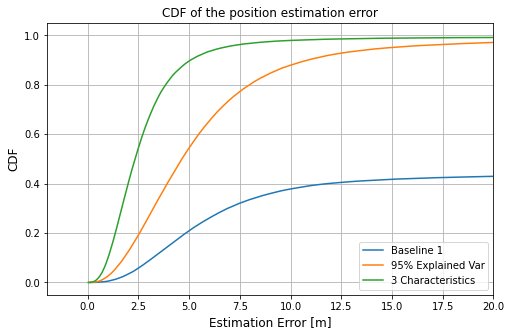

In [18]:
figure, ax = plt.subplots(1, 1, figsize=(8, 5)) 
ax.plot(np.sort(baseline_error), np.linspace(0,1,tot_points), np.sort(all_error_95), np.linspace(0,1,len(all_error_95)), 
       np.sort(all_error_3), np.linspace(0,1,len(all_error_3)))
tikzplotlib.clean_figure(fig=figure, target_resolution=600)

#plt.plot(np.sort(baseline_error), np.linspace(0,1,tot_points), linewidth=2, label="Baseline")
#plt.plot(np.sort(all_error), np.linspace(0,1,len(all_error)), linewidth=2, label="Min Delay")
#plt.plot(np.sort(all_error_all_paths), np.linspace(0,1,len(all_error_all_paths)), linewidth=2, label="All Paths")

plt.xlim([-2,20])
plt.ylabel("CDF", fontsize=12)
plt.xlabel("Estimation Error [m]", fontsize=12)
plt.title("CDF of the position estimation error")
plt.grid()
plt.legend(["Baseline 1", "95% Explained Var", "3 Characteristics", "Baseline 2"], loc="lower right")

tikzplotlib.save("./figures/pca_95_3charac_vs_baselines_noise_newarch.tex")
# plt.savefig("./dnn_vs_baseline.png")

In [19]:
print(all_error_95.shape)
# print(f"The average error for the Baseline is {np.mean(baseline_error)}")
# print(f"The average error for Hashim Baseline is {np.mean(hashim_baseline)}")
# print(f"The average error for the Min Delay DNN is {np.mean(all_error)}")
# print(f"The average error for the All Paths DNN is {np.mean(all_error_all_paths)}")

(150000,)


In [20]:
baseline_err_sort = np.sort(baseline_error)
y = np.linspace(0,1.0,len(baseline_err_sort))
print(f"BASELINE 1: the 80% percentile error in meters is {baseline_err_sort[y>=0.8][0]}")

#baseline_hash_sort = np.sort(hashim_baseline)
#y = np.linspace(0,1.0,len(baseline_hash_sort))
#print(f"BASELINE 2: the 80% percentile error in meters is {baseline_hash_sort[y>=0.8][0]}")

all_error_95_sort = np.sort(all_error_95)
y = np.linspace(0,1.0,len(all_error_95_sort))
print(f"95% Explained: the 80% percentile error in meters is {all_error_95_sort[y>=0.8][0]}")

all_error_3_sort = np.sort(all_error_3)
y = np.linspace(0,1.0,len(all_error_3_sort))
print(f"3 CHARACT: the 80% percentile error in meters is {all_error_3_sort[y>=0.8][0]}")


BASELINE 1: the 80% percentile error in meters is 377.8483316940807
95% Explained: the 80% percentile error in meters is 7.974316120147705
3 CHARACT: the 80% percentile error in meters is 3.8411877155303955
